# Example use of domus-mlsim

This python notebook shows how to run the HVAC, DV0 and DV1 simulators together with a sample controller (SimpleHvac).

The first step is to import various definitions, create a controller, and load the simulator models. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import sys
import pandas as pd
import joblib
import numpy as np
import seaborn as sns

sns.set_theme()

from domus_mlsim import (HVAC_UT_COLUMNS,
                        HVAC_XT_COLUMNS,
                        DV0_UT_COLUMNS,
                        DV0_XT_COLUMNS,
                        DV1_UT_COLUMNS,
                        DV1_XT_COLUMNS,
                        HvacUt,
                        HvacXt,
                        DV0Ut,
                        DV0Xt,
                        DV1Ut,
                        DV1Xt,
                        SimpleHvac,
                        kw_to_array,
                        MLSim,
                        KELVIN,
                        run_dv0_sim,
                        run_dv1_sim,
                        load_dv0,
                        load_dv1,
                        load_hvac,
                        )


dv0_scaler_and_model = load_dv0()
dv1_scaler_and_model = load_dv1()
hvac_scaler_and_model = load_hvac()
controller = SimpleHvac()

We define a `plot_results` function to make it easy to plot the most important variables. Alter this to add other variables or reformat the plots.

In [2]:
def plot_results(cabin, hvac, ctrl):
    cabdf = pd.DataFrame(cabin, columns=DV0_XT_COLUMNS)
    ax = cabdf.plot(y=['t_drvr1', 't_drvr2', 't_drvr3', 'ws'],)
    ax.set(xlabel='Time (s)', ylabel='Temperature (K)')

    ax = cabdf.plot(y=['v_drvr1', 'v_drvr2', 'v_drvr3'], )
    ax.set(xlabel='Time (s)', ylabel='Air velocity (m/s)')
    hvacdf = pd.DataFrame(hvac, columns=HVAC_XT_COLUMNS)
    ax = hvacdf.plot(y=HVAC_XT_COLUMNS, subplots=True,  figsize=(6,6))
    ax[0].set(xlabel='Time (s)', ylabel='Humidity')
    ax[1].set(xlabel='Time (s)', ylabel='Flow (m3/h)')
    ax[2].set(xlabel='Time (s)', ylabel='Temperature (K)')
    ax = pd.DataFrame(ctrl, columns=SimpleHvac.XT_COLUMNS).plot(
        y=SimpleHvac.XT_COLUMNS, subplots=True, figsize=(6, 10))
    ax[0].set(ylabel='Power (W)')
    ax[1].set(ylabel='Power (W)')
    ax[2].set(ylabel='Power (W)')
    ax[3].set(ylabel='Power (W)')
    ax[4].set(ylabel='Setting', ylim=(-0.1,1.1))
    ax[5].set(ylabel='Setting', ylim=(-0.1,1.1))


## DV0

We can now run a DV0 simulation (that includes simulating the HVAC and running the controller). 

Two examples are tried - warming up from $-1$ degC and cooling down from $37$ degC.

Note that although the controller tries to use window heating, the DV0 variant ignores this.

### Warm up from ambient $-1$ C

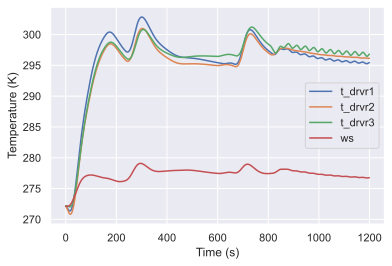

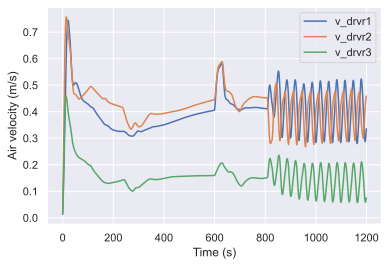

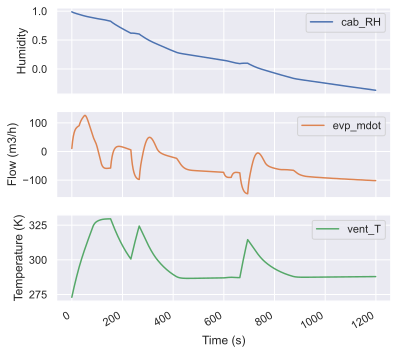

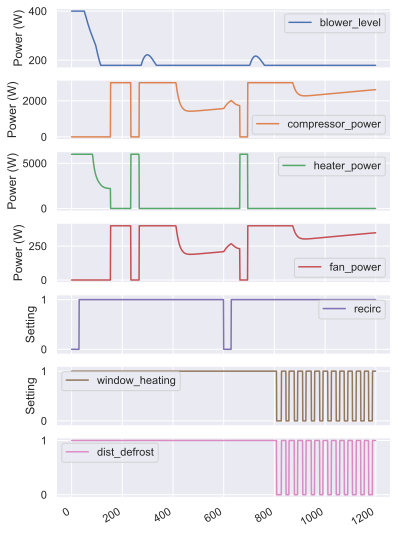

In [3]:
cabin, hvac, ctrl = run_dv0_sim(dv0_scaler_and_model,
                                hvac_scaler_and_model,
                                controller,
                                setpoint=KELVIN + 22,
                                n=1200,
                                ambient_t=KELVIN + 1,
                                ambient_rh=0.99,
                                cabin_t=KELVIN - 1,
                                cabin_v=0,
                                cabin_rh=0.99,
                                solar1=100,
                                solar2=50,
                                car_speed=100)

plot_results(cabin, hvac, ctrl)

### Cool down from 37C

The following example shows what happens when cooling. Note that cooling is not performed completely and this may reflect a fault or limitation in the DV0 simulation (it does not occur for DV1). 

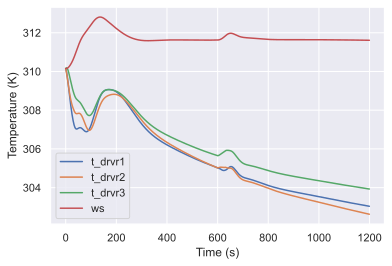

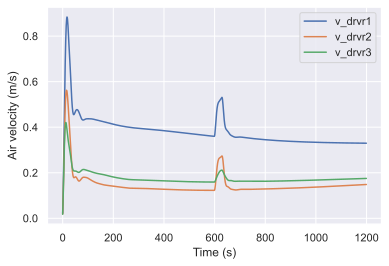

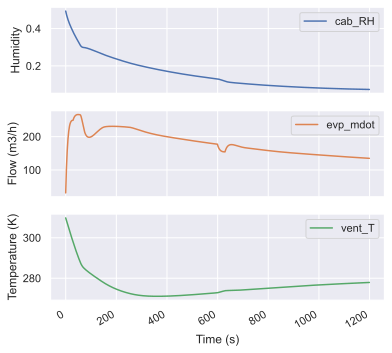

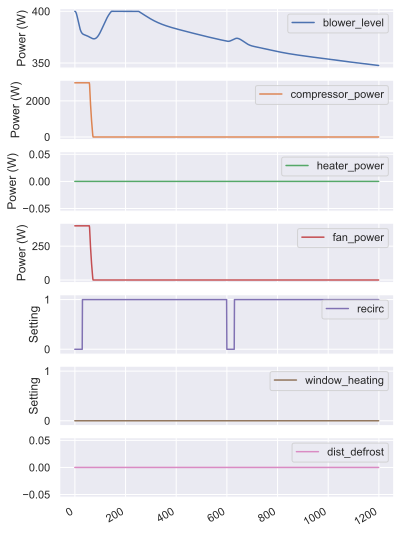

In [4]:
cabin, hvac, ctrl = run_dv0_sim(dv0_scaler_and_model, 
                                hvac_scaler_and_model,
                                controller,
                                setpoint=KELVIN + 22,
                                n=1200,
                                ambient_t=KELVIN + 37,
                                ambient_rh=0.99,
                                cabin_t=KELVIN + 37,
                                cabin_v=0,
                                cabin_rh=0.50,
                                solar1=300,
                                solar2=150,
                                car_speed=30)

plot_results(cabin, hvac, ctrl)

## DV1
### Warm up from -1C

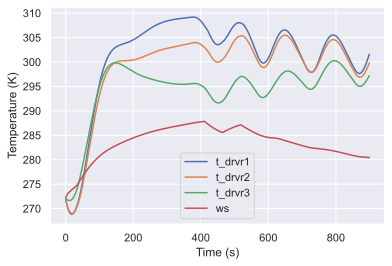

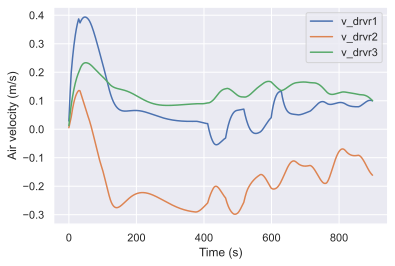

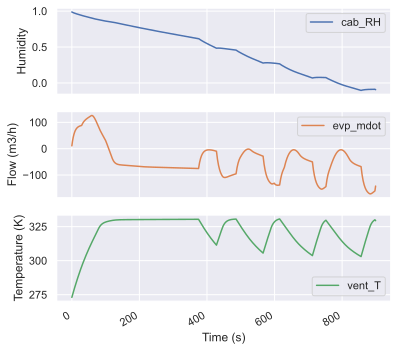

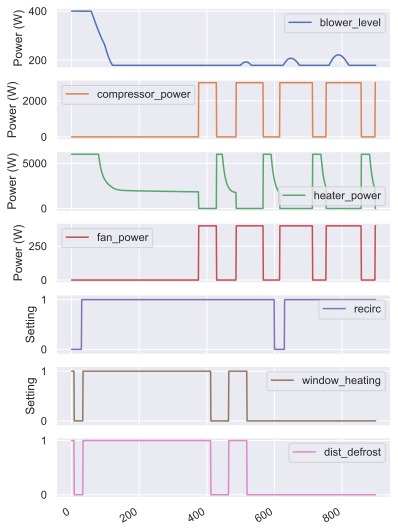

In [5]:
cabin, hvac, ctrl, b_u, h_u, c_u  = run_dv1_sim(dv1_scaler_and_model, 
                                hvac_scaler_and_model,
                                
                                controller,
                                setpoint=KELVIN + 22,
                                n=900,
                                ambient_t=KELVIN - 1,
                                ambient_rh=0.99,
                                cabin_t=KELVIN - 1,
                                cabin_v=0,
                                cabin_rh=0.99,
                                solar1=100,
                                solar2=50,
                                car_speed=0, log_inputs=True)

plot_results(cabin, hvac, ctrl)

### Cool down from 37C

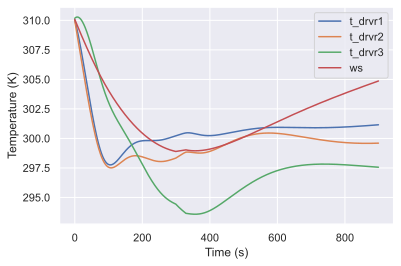

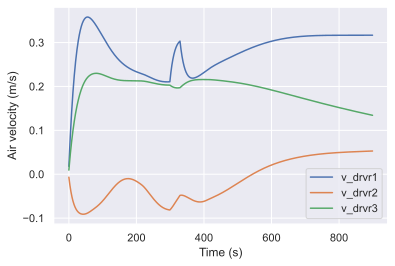

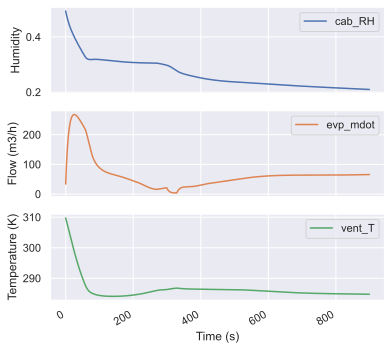

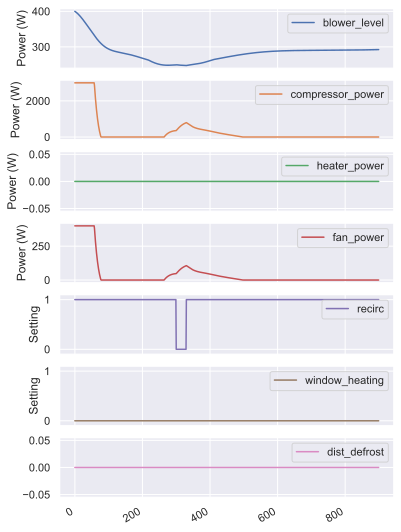

In [6]:
cabin, hvac, ctrl, b_u, h_u, c_u = run_dv1_sim(dv1_scaler_and_model, 
                                hvac_scaler_and_model,
                                controller,
                                setpoint=KELVIN + 22,
                                n=900,
                                ambient_t=KELVIN + 37,
                                ambient_rh=0.99,
                                cabin_t=KELVIN + 37,
                                cabin_v=0,
                                cabin_rh=0.50,
                                solar1=300,
                                solar2=150,
                                car_speed=30, log_inputs=True)

plot_results(cabin, hvac, ctrl)

# Compute performance

In [7]:
%%timeit 
cabin, hvac, ctrl = run_dv1_sim(dv1_scaler_and_model, hvac_scaler_and_model, controller,
                                                        setpoint=KELVIN + 22,
                                                        n=1,
                                                        ambient_t=KELVIN + 37,
                                                        ambient_rh=0.99,
                                                        cabin_t=KELVIN + 37,
                                                        cabin_v=0,
                                                        cabin_rh=0.50,
                                                        solar1=300,
                                                        solar2=150,
                                                        car_speed=30, log_inputs=False)

752 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
%%timeit
cabin, hvac, ctrl = run_dv0_sim(dv0_scaler_and_model,
                                hvac_scaler_and_model,
                                controller,
                                setpoint=KELVIN + 22,
                                n=1,
                                ambient_t=KELVIN + 1,
                                ambient_rh=0.99,
                                cabin_t=KELVIN - 1,
                                cabin_v=0,
                                cabin_rh=0.99,
                                solar1=100,
                                solar2=50,
                                car_speed=100)

738 µs ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
from domus_mlsim import make_dv0_sim, make_hvac_sim, update_control_inputs_dv0, update_hvac_inputs
cabin_t = KELVIN - 1
cabin_v = 0
cabin_rh = 0.99
ambient_t = KELVIN - 1
ambient_rh = 0.99
solar1 = 0
solar2 = 0
car_speed = 27
n = 1
setpoint = KELVIN + 22
b_x = kw_to_array(
    DV0_XT_COLUMNS,
    t_drvr1=cabin_t,
    t_drvr2=cabin_t,
    t_drvr3=cabin_t,
    t_psgr1=cabin_t,
    t_psgr2=cabin_t,
    t_psgr3=cabin_t,
    t_psgr21=cabin_t,
    t_psgr22=cabin_t,
    t_psgr23=cabin_t,
    t_psgr31=cabin_t,
    t_psgr32=cabin_t,
    t_psgr33=cabin_t,
    v_drvr1=cabin_v,
    v_drvr2=cabin_v,
    v_drvr3=cabin_v,
    v_psgr1=cabin_v,
    v_psgr2=cabin_v,
    v_psgr3=cabin_v,
    v_psgr21=cabin_v,
    v_psgr22=cabin_v,
    v_psgr23=cabin_v,
    v_psgr31=cabin_v,
    v_psgr32=cabin_v,
    v_psgr33=cabin_v,
    m_drvr1=cabin_t,
    m_drvr2=cabin_t,
    m_drvr3=cabin_t,
    m_psgr1=cabin_t,
    m_psgr2=cabin_t,
    m_psgr3=cabin_t,
    m_psgr21=cabin_t,
    m_psgr22=cabin_t,
    m_psgr23=cabin_t,
    m_psgr31=cabin_t,
    m_psgr32=cabin_t,
    m_psgr33=cabin_t,
    rhc=cabin_rh,
    ws=cabin_t,
)
h_x = kw_to_array(
    HVAC_XT_COLUMNS, cab_RH=cabin_rh, evp_mdot=cabin_v, vent_T=cabin_t
)

cabin_mlsim = make_dv0_sim(dv0_scaler_and_model, b_x)

hvac_mlsim = make_hvac_sim(hvac_scaler_and_model, h_x)

cabin = np.zeros((n, len(b_x)))
cabin[0] = b_x
hvac = np.zeros((n, len(h_x)))
hvac[0] = h_x
ctrl = np.zeros((n, len(SimpleHvac.Xt)))
c_u = np.zeros((len(controller.Ut)))
c_u[controller.Ut.setpoint] = setpoint
h_u = np.zeros((len(HvacUt)))
h_u[[HvacUt.ambient, HvacUt.humidity, HvacUt.solar, HvacUt.speed]] = [
    ambient_t,
    ambient_rh,
    solar1,
    car_speed,
]
b_u = np.zeros((len(DV0Ut)))
b_u[
    [
        DV0Ut.t_a,
        DV0Ut.rh_a,
        DV0Ut.rad1,
        DV0Ut.rad2,
        DV0Ut.VehicleSpeed,
    ]
] = [ambient_t, ambient_rh, solar1, solar2, car_speed / 100 * 27.778]
# average temperature over front bench
cab_t = cabin_t
update_control_inputs_dv0(c_u, b_x, h_x, cab_t)
#    print(c_u, cab_t)
c_x = controller.step(c_u)

# drive HVAC
update_hvac_inputs(h_u, c_x, cab_t)
#    print(h_u)


In [10]:
%%timeit
_, h_x = hvac_mlsim.step(h_u)


222 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
from domus_mlsim import update_dv0_inputs
update_dv0_inputs(b_u, h_x, c_x)


In [12]:
%%timeit
_, b_x = cabin_mlsim.step(b_u)


215 µs ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [13]:
from domus_mlsim import update_dv1_inputs, make_dv1_sim
b_x = kw_to_array(
    DV1_XT_COLUMNS,
    t_drvr1=cabin_t,
    t_drvr2=cabin_t,
    t_drvr3=cabin_t,
    t_psgr1=cabin_t,
    t_psgr2=cabin_t,
    t_psgr3=cabin_t,
    t_psgr21=cabin_t,
    t_psgr22=cabin_t,
    t_psgr23=cabin_t,
    t_psgr31=cabin_t,
    t_psgr32=cabin_t,
    t_psgr33=cabin_t,
    v_drvr1=cabin_v,
    v_drvr2=cabin_v,
    v_drvr3=cabin_v,
    v_psgr1=cabin_v,
    v_psgr2=cabin_v,
    v_psgr3=cabin_v,
    v_psgr21=cabin_v,
    v_psgr22=cabin_v,
    v_psgr23=cabin_v,
    v_psgr31=cabin_v,
    v_psgr32=cabin_v,
    v_psgr33=cabin_v,
    m_drvr1=cabin_t,
    m_drvr2=cabin_t,
    m_drvr3=cabin_t,
    m_psgr1=cabin_t,
    m_psgr2=cabin_t,
    m_psgr3=cabin_t,
    m_psgr21=cabin_t,
    m_psgr22=cabin_t,
    m_psgr23=cabin_t,
    m_psgr31=cabin_t,
    m_psgr32=cabin_t,
    m_psgr33=cabin_t,
    rhc=cabin_rh,
    ws=cabin_t,
)
cabin_mlsim = make_dv1_sim(dv1_scaler_and_model, b_x)
b_u = np.zeros((len(DV1Ut)))
b_u[
    [
        DV1Ut.t_a,
        DV1Ut.rh_a,
        DV1Ut.rad1,
        DV1Ut.rad2,
        DV1Ut.VehicleSpeed,
    ]
] = [ambient_t, ambient_rh, solar1, solar2, car_speed / 100 * 27.778]
update_dv1_inputs(b_u, h_x, c_x)


In [14]:
%%timeit
_, b_x = cabin_mlsim.step(b_u)


213 µs ± 10.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
